# To test the limit of the method

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

from gammapy.data import DataStore
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D, EnergyDependentMultiGaussPSF, Background3D
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube import MapFit, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.cube.models import SkyModel, SkyModels
from gammapy.cube.exposure import _map_spectrum_weight
import iminuit
from importlib import reload
import MyLikelihood_3d_hess
reload (MyLikelihood_3d_hess)
from MyLikelihood_3d_hess import *

In [108]:
def get_irfs():
    filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(filename, hdu='POINT SPREAD FUNCTION')
    aeff = EffectiveAreaTable2D.read(filename, hdu='EFFECTIVE AREA')
    edisp = EnergyDispersion2D.read(filename, hdu='ENERGY DISPERSION')
    bkg = Background3D.read(filename, hdu='BACKGROUND')
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)

irfs=get_irfs()

In [109]:
#define the geom
src=SkyCoord(280.4652, -32.8884, unit='deg', frame='galactic')
elow = 0.8
ehigh = 20.0
energy_axis = MapAxis.from_bounds(elow, ehigh, 30, name='energy', unit='TeV', interp='log')
geom3d = WcsGeom.create(binsz=0.25, skydir=src, width=7.0, coordsys='GAL',
                       axes=[energy_axis])
energy_axis_1bin = MapAxis.from_bounds(elow, ehigh, 1, name='energy', unit='TeV', interp='log')
geom2d = geom3d.to_image().to_cube(axes=[energy_axis_1bin])

Same exposure and banckground

In [110]:
livetime = 10 * u.hour
offset_max = 2.3 * u.deg
pointing=src

exposure_map3d = make_map_exposure_true_energy(
        pointing=pointing, livetime=livetime, aeff=irfs['aeff'],
        geom=geom3d
        )
    
background3d = make_map_background_irf(
        pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom3d
        ) 

In [111]:
background2d =  background3d.sum_over_axes()
b1 = np.reshape(background2d.data,(1,background2d.data.shape[0],background2d.data.shape[0]))
background = WcsNDMap(geom2d, b1)
spectrum = PowerLaw(index=2.0)
wt = _map_spectrum_weight(exposure_map3d, spectrum)
exposure2d = wt.sum_over_axes()
e1 = np.reshape(exposure2d.data,(1,exposure2d.data.shape[0],exposure2d.data.shape[0]))
exposure_map = WcsNDMap(geom2d, e1, unit=exposure_map3d.unit)

In [112]:
def return_npred(ampl, sigma=1.0 * u.deg):
    spatial_model = SkyGaussian(
        lon_0=src.galactic.l,
        lat_0=src.galactic.b,
        sigma=sigma,
    )
    spectral_model = PowerLaw(
        index=2.0,
        amplitude=ampl,
        reference='1 TeV',
    )
    sky_model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
    )
    evaluator = MapEvaluator(sky_model, exposure_map)
    npred = evaluator.compute_npred()
    return npred

In [113]:
amp_arr = np.logspace(np.log10(1e-13), np.log10(1e-11), 20)/(u.cm *u.cm * u.s *u.TeV)
sigma_arr = np.array([0.25, 0.5, 1.0, 2.0])*u.deg

In [114]:
n_obs = 20
mu_b = 1.0
sig_b = 0.2

each_sigma = dict()
reco_sign = dict()
reco_frac = dict()

for sigma in sigma_arr:
    print(sigma)
    each_amp = []
    signf = []
    frac = []
    for ampl in amp_arr:

        exp_map = []
        bkg_map = []
        diffuse_map = []
        back_factor = [] #Unknown back normalisation in real life
        for i in range(n_obs):    
    
            factor_b = np.random.normal(mu_b, sig_b)
            if factor_b < 0.0:
                print(factor_b)
                continue
        
    
            back_data = background.data * factor_b
            npred = return_npred(ampl, sigma=sigma)
            rng = np.random.RandomState()
            counts = rng.poisson(npred)
            counts = counts + back_data
        
            counts_map = WcsNDMap(geom2d, counts)
            exp_map.append(exposure_map)
            bkg_map.append(background)
            diffuse_map.append(counts_map)
            back_factor.append(factor_b)
        
        frac.append(npred.sum()/background.data.sum())
        mle = MyLikelihood(count_list=diffuse_map, exposure_list=exp_map, background_list=bkg_map)
        
        
        kwarg_fix = dict(
            lon0 =  src.galactic.l.value,
            lat0 = src.galactic.b.value,           
            amp = 1.1 * ampl.value,
            sig = 1.1* sigma.value,
            error_amp = ampl.value/10.0,
            limit_amp = (0.0, 1e-6),
            error_sig = 0.1,
            limit_sig = (0.1,10),
            fix_sig = False,
            fix_lon0 = True,
            fix_lat0 = True
            )
        m = iminuit.Minuit(mle, print_level=0, errordef=1, **kwarg_fix)
        m.migrad()
        each_amp.append(m)
        # now calculate significance
        L1 =  mle.calc_res(src.galactic.l, src.galactic.b, m.values['sig']*u.deg, m.values['amp']*ampl.unit, )
        L0 =  mle.calc_res(src.galactic.l, src.galactic.b, m.values['sig']*u.deg, 0.0*ampl.unit, )
        signf.append(L0 - L1)
    each_sigma[sigma.value] = each_amp
    reco_sign[sigma.value] = signf
    reco_frac[sigma.value] = frac

0.25 deg
0.5 deg


/Users/asinha/Gammapy-dev/LMC/MyLikelihood_3d_hess.py:108: RuntimeWarning: invalid value encountered in sqrt
  bk2 = (np.sum(Nk)/np.sum(Bk) + np.sqrt(delta))/2.0
/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    lon0 = +280.465200
    lat0 = -32.888400
     sig = +8.952632
     amp = +0.000000

/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    lon0 = +280.465200
    lat0 = -32.888400
     sig = nan
     amp = nan



1.0 deg
2.0 deg


/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    lon0 = +280.465200
    lat0 = -32.888400
     sig = +3.341891
     amp = +0.000000

/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    lon0 = +280.465200
    lat0 = -32.888400
     sig = +2.995248
     amp = +0.000001

/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    lon0 = +280.465200
    lat0 = -32.888400
     sig = +2.016181
     amp = +0.000000

/Users/asinha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    lon0 = +280.465200
    lat0 = -32.888400
     sig = +2.811384
     amp = +0.000000

/Users/asinha/anaconda3/lib/python3.6/site-packa

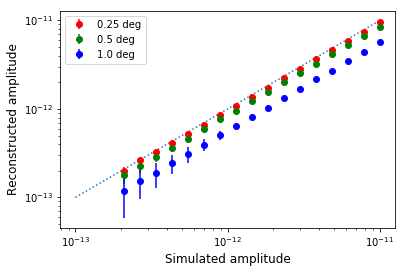

In [115]:
#plot reco amp
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:-1],color):
    amp=[]
    [amp.append(each_sigma[sigma.value][i].values['amp']) for i in range(20)]
    amp_err = []
    [amp_err.append(each_sigma[sigma.value][i].errors['amp']) for i in range(20)]
    plt.errorbar(amp_arr.value[3:], amp[3:], yerr=amp_err[3:], fmt="o", color=color, label=sigma)
plt.plot(amp_arr, amp_arr, linestyle='dotted')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Simulated amplitude", fontsize = 'large')
plt.ylabel("Reconstructed amplitude", fontsize = 'large')
plt.legend()

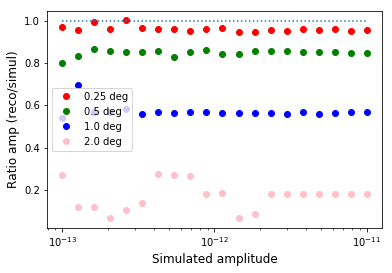

In [116]:
#plot reco amp_ratio
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:],color):
    amp=[]
    [amp.append(each_sigma[sigma.value][i].values['amp']) for i in range(20)]
    amp_err = []
    [amp_err.append(each_sigma[sigma.value][i].errors['amp']) for i in range(20)]
    plt.plot(amp_arr.value, amp/amp_arr.value, "o", color=color, label=sigma)
plt.plot(amp_arr, amp_arr/amp_arr, linestyle='dotted')
plt.xscale("log")
plt.yscale("linear")
plt.xlabel("Simulated amplitude", fontsize = 'large')
plt.ylabel("Ratio amp (reco/simul)", fontsize = 'large')
plt.legend()

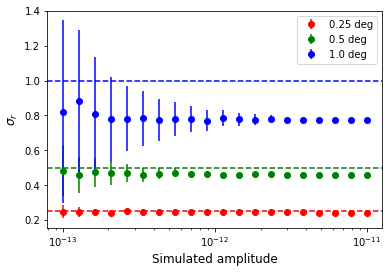

In [117]:
#plot reco sigma
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:-1],color):
    amp=[]
    [amp.append(each_sigma[sigma.value][i].values['sig']) for i in range(20)]
    amp_err = []
    [amp_err.append(each_sigma[sigma.value][i].errors['sig']) for i in range(20)]
    plt.errorbar(amp_arr.value, amp, yerr=amp_err, fmt="o", color=color, label=sigma)
    plt.axhline(sigma.value, color=color, linestyle='dashed')
plt.xscale("log")
plt.yscale("linear")
plt.xlabel("Simulated amplitude", fontsize = 'large')
plt.ylabel("$\sigma_r$", fontsize = 'large')
plt.legend()

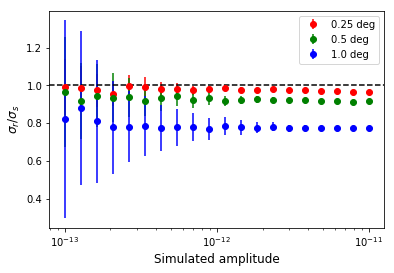

In [118]:
#plot reco sigma ratio
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:-1],color):
    amp=[]
    [amp.append(each_sigma[sigma.value][i].values['sig']) for i in range(20)]
    amp_err = []
    [amp_err.append(each_sigma[sigma.value][i].errors['sig']) for i in range(20)]
    plt.errorbar(amp_arr.value, amp/np.array(sigma.value), yerr=np.array(amp_err)/np.array(sigma.value), fmt="o", color=color, label=sigma)
    #plt.plot(amp_arr.value, np.power(np.power(amp,1.2)/np.array(sigma.value),1.0), "o", color=color, label=sigma)
plt.axhline(1.0, color="black", linestyle='dashed')
plt.xscale("log")
plt.yscale("linear")
plt.xlabel("Simulated amplitude", fontsize = 'large')
plt.ylabel("$\sigma_{r}/\sigma_{s}$", fontsize = 'large')
plt.legend()

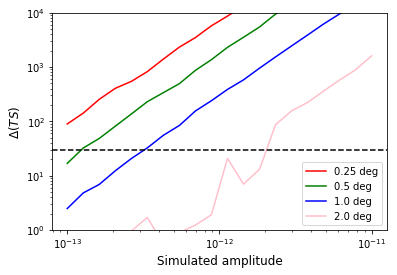

In [119]:
#plot significance
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:],color):
    plt.plot(amp_arr, np.array(reco_sign[sigma.value]) * 2.0, color=color, label=sigma)
plt.axhline(y=30.0, color='black', linestyle='dashed')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1.0, 1e4)
plt.xlabel("Simulated amplitude", fontsize = 'large')
plt.ylabel("$\Delta(TS)$", fontsize = 'large')
plt.legend()

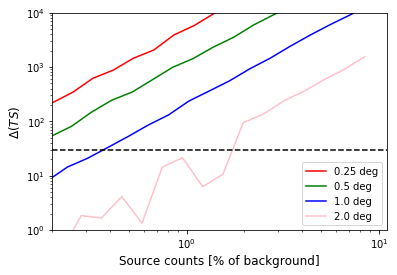

In [72]:
#plot significance
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:],color):
    plt.plot(np.array(reco_frac[sigma.value])*100.0, np.array(reco_sign[sigma.value]) * 2.0, color=color, label=sigma)
plt.axhline(y=30.0, color='black', linestyle="dashed")
plt.xscale("log")
plt.xlim(0.2,11.0)
plt.yscale("log")
plt.ylim(1.0, 1e4)
plt.xlabel("Source counts [% of background]", fontsize = 'large')
plt.ylabel("$\Delta(TS)$", fontsize = 'large')
plt.legend()


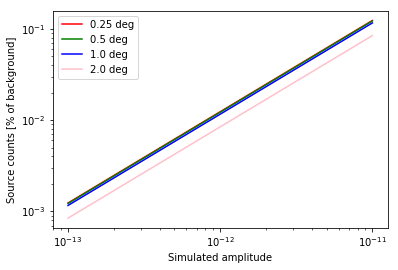

In [74]:
#plot fraction
color=["red", "green", "blue", "pink"]
for sigma,color in zip(sigma_arr[0:],color):
    plt.plot(amp_arr, np.array(reco_frac[sigma.value]), color=color, label=sigma)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Source counts [% of background]")
plt.xlabel("Simulated amplitude")
plt.legend()

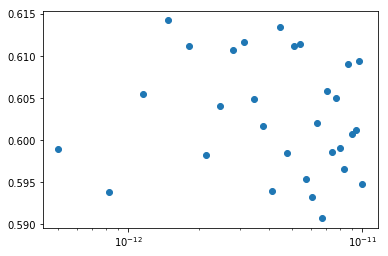

In [100]:
plt.plot(amp_arr.value, np.array(amp_val)/amp_arr.value, "o")
#plt.plot(amp_arr.value,amp_arr.value,linestyle = "solid")
plt.yscale("linear")
plt.xscale("log")

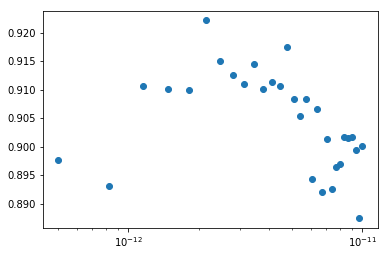

In [78]:
plt.plot(amp_arr.value, np.array(amp_val)/amp_arr.value, "o")
#plt.plot(amp_arr.value,amp_arr.value,linestyle = "solid")
plt.yscale("linear")
plt.xscale("log")